In [5]:
import os
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

In [98]:
%pip install cornac

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
import sys
import pandas as pd
from cornac.models import BPR
from cornac.data import Dataset
import movielens

from python_splitters import python_random_split
from python_evaluation import map, ndcg_at_k, precision_at_k, recall_at_k
from cornac_utils import predict_ranking
from timer import Timer
from constants import SEED
from notebook_utils import store_metadata

#### Bayesian Personalized Ranking (BPR)

In [194]:
ancillaries = [
    'PAID_SEATS',
    'EXTRA_BAGGAGE',
    'SPECIAL_EQUIPMENT',
    'FAST_TRACK',
    'ONBOARD_MEALS',
    'BUSINESS_LOUNGE'
]

##### Modelling with BPR (Negative sampling/Positive sampling)

In [7]:
bpr = pd.read_csv("bpr_data.csv")

In [8]:
bpr.head()

,COOKIE_ID,PAID_SEATS,EXTRA_BAGGAGE,SPECIAL_EQUIPMENT,FAST_TRACK,ONBOARD_MEALS,BUSINESS_LOUNGE
0,90160409479417649411999102181002937619,0,0,0,0,0,0
1,83506423751136985820103526870163297871,0,0,0,0,0,0
2,78236612428921115877508527232487027464,0,0,0,0,0,0
3,86513654906858836814951255651058285578,0,0,0,0,0,0
4,07263717780177747617979091720349832062,0,0,0,0,0,0


In [462]:
bpr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323762 entries, 0 to 1323761
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   COOKIE_ID          1323762 non-null  object
 1   PAID_SEATS         1323762 non-null  int64 
 2   EXTRA_BAGGAGE      1323762 non-null  int64 
 3   SPECIAL_EQUIPMENT  1323762 non-null  int64 
 4   FAST_TRACK         1323762 non-null  int64 
 5   ONBOARD_MEALS      1323762 non-null  int64 
 6   BUSINESS_LOUNGE    1323762 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 70.7+ MB


In [463]:
bpr = bpr.rename(columns={"COOKIE_ID": "userID"})

In [464]:
# Wide → Long
bpr_long = bpr.melt(id_vars="userID", 
                    var_name="itemID", 
                    value_name="rating")

In [465]:
# Only keep positive ratings
bpr_long = bpr_long[bpr_long["rating"] > 0].copy()

In [466]:
# Convert userID in string (Cornac requires it)
bpr_long["userID"] = bpr_long["userID"].astype(str)

In [467]:
bpr_long

,userID,itemID,rating
16,86513654906858836814951255651058285578,PAID_SEATS,1
34,76228591696139306440880104031696963377,PAID_SEATS,1
36,26925697700094090916284869761824808938,PAID_SEATS,1
40,11242018832180763020260361239607379697,PAID_SEATS,1
47,07662523923729159657921368516833077772,PAID_SEATS,1
...,...,...,...
6644051,89943537493867182013839041504651892613,BUSINESS_LOUNGE,1
6645630,42153779173031232751850709676330898211,BUSINESS_LOUNGE,1
6652101,89943537493867182013839041504651892613,BUSINESS_LOUNGE,1
6652493,42153779173031232751850709676330898211,BUSINESS_LOUNGE,1


In [468]:
train, test = python_random_split(bpr_long, 0.75)

In [469]:
train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)

print('Number of users: {}'.format(train_set.num_users))
print('Number of items: {}'.format(train_set.num_items))

Number of users: 3728
Number of items: 6


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\cornac\data\dataset.py:335: UserWarning: 1927 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


In [470]:
NUM_FACTORS = 200       # розмір латентного простору
NUM_EPOCHS = 100        # кількість ітерацій SGD
SEED = 42               # фіксація випадковості для відтворюваності

In [471]:
bpr = cornac.models.BPR(
    k=NUM_FACTORS,
    max_iter=NUM_EPOCHS,
    learning_rate=0.01,
    lambda_reg=0.001,
    verbose=True,
    seed=SEED
)

In [472]:
with Timer() as t:
    bpr.fit(train_set)
print("Took {} seconds for training.".format(t))

  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Took 0.3839 seconds for training.


In [473]:
with Timer() as t:
    all_predictions = predict_ranking(bpr, train, usercol='userID', itemcol='itemID', remove_seen=True)
print("Took {} seconds for prediction.".format(t))

Took 0.0877 seconds for prediction.


In [474]:
all_predictions.head()

,userID,itemID,prediction
0,00018144326187028341560824524042711867,BUSINESS_LOUNGE,-2.694772
1,00018144326187028341560824524042711867,EXTRA_BAGGAGE,-0.693697
3,00018144326187028341560824524042711867,ONBOARD_MEALS,-0.992418
4,00018144326187028341560824524042711867,PAID_SEATS,2.794400
5,00018144326187028341560824524042711867,SPECIAL_EQUIPMENT,-2.076022


In [479]:
k = 10
eval_map = map(test, all_predictions, col_prediction='prediction', k=k)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=k)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.235209
NDCG:	0.113465
Precision@K:	0.031339
Recall@K:	0.267474


##### Modeling with BPR (count times of interactions echnique)

In [480]:
mul_bpr = bpr_long.copy()

In [481]:
mul_bpr

,userID,itemID,rating
16,86513654906858836814951255651058285578,PAID_SEATS,1
34,76228591696139306440880104031696963377,PAID_SEATS,1
36,26925697700094090916284869761824808938,PAID_SEATS,1
40,11242018832180763020260361239607379697,PAID_SEATS,1
47,07662523923729159657921368516833077772,PAID_SEATS,1
...,...,...,...
6644051,89943537493867182013839041504651892613,BUSINESS_LOUNGE,1
6645630,42153779173031232751850709676330898211,BUSINESS_LOUNGE,1
6652101,89943537493867182013839041504651892613,BUSINESS_LOUNGE,1
6652493,42153779173031232751850709676330898211,BUSINESS_LOUNGE,1


In [482]:
# Only keep positive ratings
mul_bpr = mul_bpr[bpr_long["rating"] > 0]

In [483]:
# Convert userID in string (Cornac requires it)
mul_bpr["userID"] = mul_bpr["userID"].astype(str)

In [484]:
mul_bpr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8240 entries, 16 to 6652500
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userID  8240 non-null   object
 1   itemID  8240 non-null   object
 2   rating  8240 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 257.5+ KB


In [485]:
pd.reset_option('display.max_rows')

user_item_counts = mul_bpr.groupby(['userID', 'itemID']).size().reset_index(name='rating')
user_item_counts

,userID,itemID,rating
0,00018144326187028341560824524042711867,FAST_TRACK,1
1,00052263349191245062082210035888704740,PAID_SEATS,2
2,00108287749788079103601416690698351493,PAID_SEATS,2
3,00119468372394589022085309109202745472,EXTRA_BAGGAGE,1
4,00125644831722302999031561193061259473,EXTRA_BAGGAGE,1
...,...,...,...
5335,92200217513321375451333500029254866641,PAID_SEATS,1
5336,92213873743303758742279321513483448605,EXTRA_BAGGAGE,1
5337,92213873743303758742279321513483448605,PAID_SEATS,1
5338,92214031300286259373510234220666798473,PAID_SEATS,2


In [486]:
user_item_counts['rating'].unique()

array([  1,   2,   3,   7,   6,   9,   4,   5,  27,  17,  14,  15,  11,
        62,  16,  21,  10,  13,  25,   8,  66,  12,  20,  30,  19,  18,
       322], dtype=int64)

In [487]:
train_1, test_1 = python_random_split(user_item_counts, 0.75)

In [488]:
train_1

,userID,itemID,rating
152,02431517670268554470305605958526991221,PAID_SEATS,1
4885,84493545070298321981664829575623723124,EXTRA_BAGGAGE,2
2899,49255394194605261922379411000319487762,EXTRA_BAGGAGE,1
5009,86334007057579978401209180867642879620,PAID_SEATS,1
3941,67999514030559672702316810325415909421,PAID_SEATS,1
...,...,...,...
3092,52875757249300329152240399774466923798,PAID_SEATS,1
3772,64889228841640846013549633336822422451,EXTRA_BAGGAGE,1
5191,89615785269324605073328555404579208967,PAID_SEATS,1
5226,90160409479417649411999102181002937619,PAID_SEATS,1


In [489]:
train_set_1 = cornac.data.Dataset.from_uir(train_1.itertuples(index=False), seed=SEED)

print('Number of users: {}'.format(train_set_1.num_users))
print('Number of items: {}'.format(train_set_1.num_items))

Number of users: 3587
Number of items: 6


In [490]:
train_set_1 

In [491]:
# Задаємо параметри моделі
NUM_FACTORS = 200
NUM_EPOCHS = 100
SEED = 42

# Ініціалізація моделі
bpr = BPR(
    k=NUM_FACTORS,
    max_iter=NUM_EPOCHS,
    learning_rate=0.01,
    lambda_reg=0.001,
    verbose=True,
    seed=SEED
)

In [492]:
with Timer() as t:
    bpr.fit(train_set_1)
print("Took {} seconds for training.".format(t))

  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Took 0.3519 seconds for training.


In [493]:
with Timer() as t:
    all_predictions_1 = predict_ranking(bpr, train_1, usercol='userID', itemcol='itemID', remove_seen=True)
print("Took {} seconds for prediction.".format(t))

Took 0.0709 seconds for prediction.


In [494]:
all_predictions_1.head()

,userID,itemID,prediction
0,00018144326187028341560824524042711867,BUSINESS_LOUNGE,-2.807282
1,00018144326187028341560824524042711867,EXTRA_BAGGAGE,0.019076
3,00018144326187028341560824524042711867,ONBOARD_MEALS,-1.218242
4,00018144326187028341560824524042711867,PAID_SEATS,2.369949
5,00018144326187028341560824524042711867,SPECIAL_EQUIPMENT,-1.962404


In [495]:
k = 1
eval_map_1 = map(test_1, all_predictions_1, col_prediction='prediction', k=k)
eval_ndcg_1 = ndcg_at_k(test_1, all_predictions_1, col_prediction='prediction', k=k)
eval_precision_1 = precision_at_k(test_1, all_predictions_1, col_prediction='prediction', k=k)
eval_recall_1 = recall_at_k(test_1, all_predictions_1, col_prediction='prediction', k=k)

print("MAP:\t%f" % eval_map_1,
      "NDCG:\t%f" % eval_ndcg_1,
      "Precision@K:\t%f" % eval_precision_1,
      "Recall@K:\t%f" % eval_recall_1, sep='\n')

MAP:	0.744848
NDCG:	0.164577
Precision@K:	0.763636
Recall@K:	0.744848


In [496]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Перелік сервісів (таргетних змінних)
services = ['PAID_SEATS', 'ONBOARD_MEALS', 'EXTRA_BAGGAGE', 'BUSINESS_LOUNGE', 'SPECIAL_EQUIPMENT', 'FAST_TRACK']

# Створимо список для збереження результатів
service_metrics = []

# Перетворимо тест і передбачення на словники для зручності доступу
gt = test_1.groupby('userID')['itemID'].apply(set).to_dict()
pred = all_predictions_1.groupby('userID')['itemID'].apply(list).to_dict()

In [497]:
# Обчислення метрик по кожному сервісу
for service in services:
    y_true = []
    y_pred = []

    for user in gt.keys():
        y_true.append(1 if service in gt[user] else 0)
        y_pred.append(1 if service in pred.get(user, []) else 0)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = float('nan')  # якщо тільки один клас

    service_metrics.append({
        'Ancillary Service': service,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc
    })

In [498]:
service_metrics

[{'Ancillary Service': 'PAID_SEATS',
  'Precision': 0.8888888888888888,
  'Recall': 0.13793103448275862,
  'F1-Score': 0.23880597014925373,
  'AUC-ROC': 0.5538793103448276},
 {'Ancillary Service': 'ONBOARD_MEALS',
  'Precision': 0.08870967741935484,
  'Recall': 0.34375,
  'F1-Score': 0.14102564102564102,
  'AUC-ROC': 0.5786406765676567},
 {'Ancillary Service': 'EXTRA_BAGGAGE',
  'Precision': 0.5161290322580645,
  'Recall': 0.2719546742209632,
  'F1-Score': 0.3562152133580705,
  'AUC-ROC': 0.5872232742719117},
 {'Ancillary Service': 'BUSINESS_LOUNGE',
  'Precision': 0.007380073800738007,
  'Recall': 0.6666666666666666,
  'F1-Score': 0.014598540145985401,
  'AUC-ROC': 0.7276774024613772},
 {'Ancillary Service': 'SPECIAL_EQUIPMENT',
  'Precision': 0.029850746268656716,
  'Recall': 0.47058823529411764,
  'F1-Score': 0.056140350877192984,
  'AUC-ROC': 0.6320375648273607},
 {'Ancillary Service': 'FAST_TRACK',
  'Precision': 0.19574468085106383,
  'Recall': 0.5348837209302325,
  'F1-Score': 0

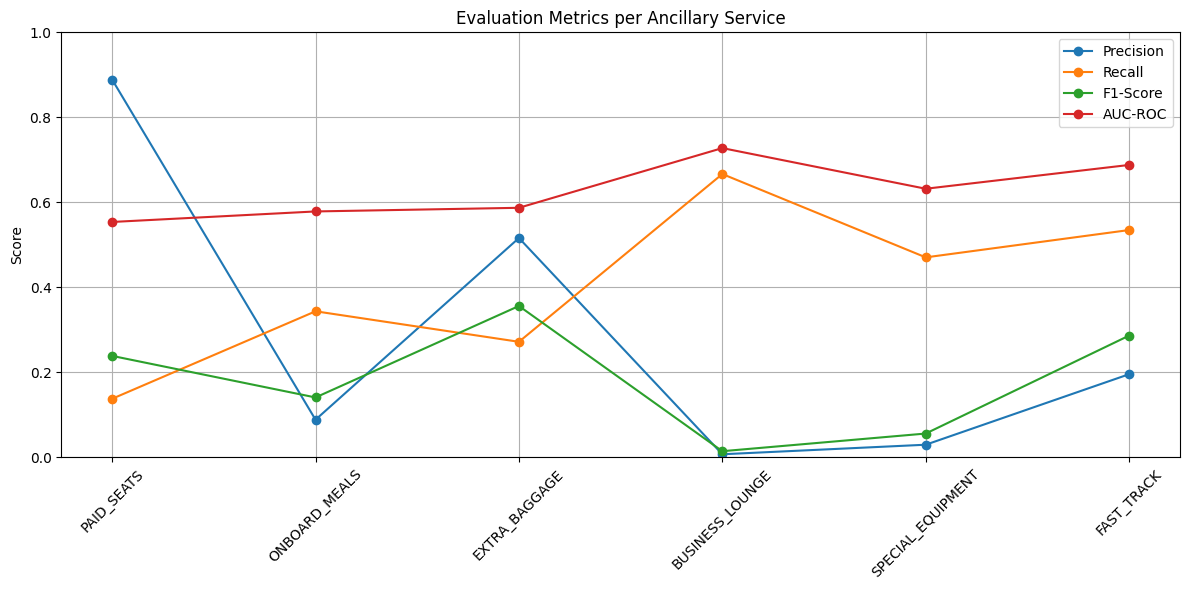

In [499]:
import matplotlib.pyplot as plt
import pandas as pd

# Перетворюємо список результатів у DataFrame
df_metrics = pd.DataFrame(service_metrics)

# Побудова графіка
metrics = ['Precision', 'Recall', 'F1-Score', 'AUC-ROC']
fig, ax = plt.subplots(figsize=(12, 6))

for metric in metrics:
    ax.plot(df_metrics['Ancillary Service'], df_metrics[metric], marker='o', label=metric)

ax.set_title('Evaluation Metrics per Ancillary Service')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### Tuning BPR

In [500]:
mul_bpr_tun = bpr_long.copy()

In [501]:
mul_bpr_tun

,userID,itemID,rating
16,86513654906858836814951255651058285578,PAID_SEATS,1
34,76228591696139306440880104031696963377,PAID_SEATS,1
36,26925697700094090916284869761824808938,PAID_SEATS,1
40,11242018832180763020260361239607379697,PAID_SEATS,1
47,07662523923729159657921368516833077772,PAID_SEATS,1
...,...,...,...
6644051,89943537493867182013839041504651892613,BUSINESS_LOUNGE,1
6645630,42153779173031232751850709676330898211,BUSINESS_LOUNGE,1
6652101,89943537493867182013839041504651892613,BUSINESS_LOUNGE,1
6652493,42153779173031232751850709676330898211,BUSINESS_LOUNGE,1


In [502]:
# Convert userID in string (Cornac requires it)
mul_bpr_tun["userID"] = mul_bpr_tun["userID"].astype(str)

In [503]:
mul_bpr_tun_group = mul_bpr_tun.groupby(['userID', 'itemID']).size().reset_index(name='rating')
mul_bpr_tun_group

,userID,itemID,rating
0,00018144326187028341560824524042711867,FAST_TRACK,1
1,00052263349191245062082210035888704740,PAID_SEATS,2
2,00108287749788079103601416690698351493,PAID_SEATS,2
3,00119468372394589022085309109202745472,EXTRA_BAGGAGE,1
4,00125644831722302999031561193061259473,EXTRA_BAGGAGE,1
...,...,...,...
5335,92200217513321375451333500029254866641,PAID_SEATS,1
5336,92213873743303758742279321513483448605,EXTRA_BAGGAGE,1
5337,92213873743303758742279321513483448605,PAID_SEATS,1
5338,92214031300286259373510234220666798473,PAID_SEATS,2


In [504]:
train_val, test_tun = python_random_split(user_item_counts, 0.8, seed=SEED)

In [505]:
train_tun, val_tun = python_random_split(train_val, 0.8, seed=SEED)

In [334]:
train_tun.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3417 entries, 2628 to 1551
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userID  3417 non-null   object
 1   itemID  3417 non-null   object
 2   rating  3417 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 106.8+ KB


In [335]:
val_tun.info()

<class 'pandas.core.frame.DataFrame'>
Index: 855 entries, 2692 to 830
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userID  855 non-null    object
 1   itemID  855 non-null    object
 2   rating  855 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 26.7+ KB


In [336]:
test_tun.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1068 entries, 3365 to 1371
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userID  1068 non-null   object
 1   itemID  1068 non-null   object
 2   rating  1068 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 33.4+ KB


In [506]:
from cornac.data import Dataset

train_tun_c = Dataset.from_uir(train_tun.itertuples(index=False), seed=SEED)
val_tun_c = Dataset.from_uir(val_tun.itertuples(index=False), seed=SEED)
test_tun_c = Dataset.from_uir(test_tun.itertuples(index=False), seed=SEED)

In [521]:
from cornac.eval_methods import BaseMethod

train_data = list(train_tun.itertuples(index=False, name=None))
test_data = list(val_tun.itertuples(index=False, name=None))

eval_method = BaseMethod.from_splits(
    train_data=train_data,
    test_data=test_data,
    fmt='UIR',
    rating_threshold=1,
    seed=SEED
)

In [526]:
from cornac.models import BPR
from cornac.metrics import Recall
from cornac.experiment import Experiment
import pandas as pd

# Параметри для перебору
k_values = [10, 50, 100]
lr_values = [0.005, 0.01]
reg_values = [0.001, 0.01]
n_iter_values = [50, 100]

results = []

for k in k_values:
    for lr in lr_values:
        for reg in reg_values:
            for n_iter in n_iter_values:
                print(f"🔧 Тест: k={k}, lr={lr}, reg={reg}, iter={n_iter}")
                
                model = BPR(
                    k=k,
                    learning_rate=lr,
                    lambda_reg=reg,
                    max_iter=n_iter,
                    verbose=False,
                    seed=SEED
                )

                experiment = Experiment(
                    eval_method=eval_method,
                    models=[model],
                    metrics=[Recall(k=3)],
                    user_based=True,
                    verbose=False
                )

                experiment.run()

                #recall_score = experiment.result[0][1].value  # модель 0, метрика 1
                recall_score = experiment.result[0].metric_avg_results['Recall@3']
                results.append({
                    'k': k,
                    'learning_rate': lr,
                    'lambda_reg': reg,
                    'max_iter': n_iter,
                    'recall@3': recall_score
                })

# Результати
tuning_results = pd.DataFrame(results)
tuning_results = tuning_results.sort_values(by='recall@3', ascending=False)
print(tuning_results.head())


🔧 Тест: k=10, lr=0.005, reg=0.001, iter=50

TEST:
...
    | Recall@3 | Train (s) | Test (s)
--- + -------- + --------- + --------
BPR |   0.9627 |    0.0153 |   0.2388

🔧 Тест: k=10, lr=0.005, reg=0.001, iter=100

TEST:
...
    | Recall@3 | Train (s) | Test (s)
--- + -------- + --------- + --------
BPR |   0.9627 |    0.0262 |   0.1057

🔧 Тест: k=10, lr=0.005, reg=0.01, iter=50

TEST:
...
    | Recall@3 | Train (s) | Test (s)
--- + -------- + --------- + --------
BPR |   0.9627 |    0.0144 |   0.1025

🔧 Тест: k=10, lr=0.005, reg=0.01, iter=100

TEST:
...
    | Recall@3 | Train (s) | Test (s)
--- + -------- + --------- + --------
BPR |   0.9627 |    0.0272 |   0.1025

🔧 Тест: k=10, lr=0.01, reg=0.001, iter=50

TEST:
...
    | Recall@3 | Train (s) | Test (s)
--- + -------- + --------- + --------
BPR |   0.9627 |    0.0152 |   0.1053

🔧 Тест: k=10, lr=0.01, reg=0.001, iter=100

TEST:
...
    | Recall@3 | Train (s) | Test (s)
--- + -------- + --------- + --------
BPR |   0.9602 |    0.0265

In [527]:
# k=10, lr=0.005, reg=0.001, iter=50

NUM_FACTORS = 10
NUM_EPOCHS = 50
SEED = 42

# Ініціалізація моделі
bpr_tun = BPR(
    k=NUM_FACTORS,
    max_iter=NUM_EPOCHS,
    learning_rate=0.005,
    lambda_reg=0.001,
    verbose=True,
    seed=SEED
)

In [528]:
with Timer() as t:
    bpr_tun.fit(train_tun_c)
print("Took {} seconds for training.".format(t))

  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Took 0.0391 seconds for training.


In [529]:
with Timer() as t:
    all_predictions_tun = predict_ranking(bpr_tun, train_tun, usercol='userID', itemcol='itemID', remove_seen=True)
print("Took {} seconds for prediction.".format(t))

Took 0.0639 seconds for prediction.


In [530]:
all_predictions_tun

,userID,itemID,prediction
0,00018144326187028341560824524042711867,BUSINESS_LOUNGE,-2.536868
1,00018144326187028341560824524042711867,EXTRA_BAGGAGE,1.528809
3,00018144326187028341560824524042711867,ONBOARD_MEALS,-0.451173
4,00018144326187028341560824524042711867,PAID_SEATS,2.501618
5,00018144326187028341560824524042711867,SPECIAL_EQUIPMENT,-1.805407
...,...,...,...
18594,92218955318112362400345798422328641405,BUSINESS_LOUNGE,-2.539542
18596,92218955318112362400345798422328641405,FAST_TRACK,-0.153053
18597,92218955318112362400345798422328641405,ONBOARD_MEALS,-0.451095
18598,92218955318112362400345798422328641405,PAID_SEATS,2.495894


In [544]:
k = 1
eval_map_01 = map(val_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_ndcg_01 = ndcg_at_k(val_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_precision_01 = precision_at_k(val_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_recall_01 = recall_at_k(val_tun, all_predictions_tun, col_prediction='prediction', k=k)

print("MAP:\t%f" % eval_map_01,
      "NDCG:\t%f" % eval_ndcg_01,
      "Precision@k:\t%f" % eval_precision_01,
      "Recall@k:\t%f" % eval_recall_01, sep='\n')

MAP:	0.700730
NDCG:	0.118072
Precision@k:	0.715328
Recall@k:	0.700730


In [531]:
k = 1
eval_map_01 = map(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_ndcg_01 = ndcg_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_precision_01 = precision_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_recall_01 = recall_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)

print("MAP:\t%f" % eval_map_01,
      "NDCG:\t%f" % eval_ndcg_01,
      "Precision@k:\t%f" % eval_precision_01,
      "Recall@k:\t%f" % eval_recall_01, sep='\n')

MAP:	0.750000
NDCG:	0.141473
Precision@k:	0.760417
Recall@k:	0.750000


In [537]:
# Очистити змінну, якщо вона була перезаписана
try:
    del recall_score
except:
    pass

# Імпортувати заново функцію
from sklearn.metrics import recall_score


In [541]:
services = ['PAID_SEATS', 'ONBOARD_MEALS', 'EXTRA_BAGGAGE', 'BUSINESS_LOUNGE', 'SPECIAL_EQUIPMENT', 'FAST_TRACK']

# Створимо список для збереження результатів
service_metrics_tun = []

# Перетворимо тест і передбачення на словники для зручності доступу
gt_tun = test_tun.groupby('userID')['itemID'].apply(set).to_dict()
pred_tun = all_predictions_tun.groupby('userID')['itemID'].apply(list).to_dict()

In [542]:
# Обчислення метрик по кожному сервісу
for service in services:
    y_true = []
    y_pred = []

    for user in gt_tun.keys():
        y_true.append(1 if service in gt_tun[user] else 0)
        y_pred.append(1 if service in pred_tun.get(user, []) else 0)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = float('nan')  # якщо тільки один клас

    service_metrics_tun.append({
        'Ancillary Service': service,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc
    })

In [543]:
service_metrics_tun

[{'Ancillary Service': 'PAID_SEATS',
  'Precision': 0.8333333333333334,
  'Recall': 0.11645962732919254,
  'F1-Score': 0.20435967302452315,
  'AUC-ROC': 0.5388999167573797},
 {'Ancillary Service': 'ONBOARD_MEALS',
  'Precision': 0.0903954802259887,
  'Recall': 0.3076923076923077,
  'F1-Score': 0.13973799126637554,
  'AUC-ROC': 0.5717032967032968},
 {'Ancillary Service': 'EXTRA_BAGGAGE',
  'Precision': 0.5426356589147286,
  'Recall': 0.24390243902439024,
  'F1-Score': 0.33653846153846156,
  'AUC-ROC': 0.5823539040759536},
 {'Ancillary Service': 'BUSINESS_LOUNGE',
  'Precision': 0.005319148936170213,
  'Recall': 0.5,
  'F1-Score': 0.010526315789473684,
  'AUC-ROC': 0.6592233009708737},
 {'Ancillary Service': 'SPECIAL_EQUIPMENT',
  'Precision': 0.026737967914438502,
  'Recall': 0.3333333333333333,
  'F1-Score': 0.04950495049504951,
  'AUC-ROC': 0.5771878072763028},
 {'Ancillary Service': 'FAST_TRACK',
  'Precision': 0.18787878787878787,
  'Recall': 0.45588235294117646,
  'F1-Score': 0.266

In [514]:
k = 2
eval_map_02 = map(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_ndcg_02 = ndcg_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_precision_02 = precision_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_recall_02 = recall_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)

print("MAP:\t%f" % eval_map_02,
      "NDCG:\t%f" % eval_ndcg_02,
      "Precision@k:\t%f" % eval_precision_02,
      "Recall@k:\t%f" % eval_recall_02, sep='\n')

MAP:	0.830729
NDCG:	0.158355
Precision@k:	0.463542
Recall@k:	0.903646


In [515]:
k = 3
eval_map_03 = map(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_ndcg_03 = ndcg_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_precision_03 = precision_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_recall_03 = recall_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)

print("MAP:\t%f" % eval_map_03,
      "NDCG:\t%f" % eval_ndcg_03,
      "Precision@k:\t%f" % eval_precision_03,
      "Recall@k:\t%f" % eval_recall_03, sep='\n')

MAP:	0.855035
NDCG:	0.164950
Precision@k:	0.333333
Recall@k:	0.973958


In [516]:
k = 4
eval_map_04 = map(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_ndcg_04 = ndcg_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_precision_04 = precision_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_recall_04 = recall_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)

print("MAP:\t%f" % eval_map_04,
      "NDCG:\t%f" % eval_ndcg_04,
      "Precision@k:\t%f" % eval_precision_04,
      "Recall@k:\t%f" % eval_recall_04, sep='\n')

MAP:	0.861545
NDCG:	0.166714
Precision@k:	0.256510
Recall@k:	0.994792


In [517]:
k = 5
eval_map_05 = map(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_ndcg_05 = ndcg_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_precision_05 = precision_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_recall_05 = recall_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)

print("MAP:\t%f" % eval_map_05,
      "NDCG:\t%f" % eval_ndcg_05,
      "Precision@k:\t%f" % eval_precision_05,
      "Recall@k:\t%f" % eval_recall_05, sep='\n')

MAP:	0.862587
NDCG:	0.167089
Precision@k:	0.206250
Recall@k:	1.000000


In [518]:
k = 6
eval_map_06 = map(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_ndcg_06 = ndcg_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_precision_06 = precision_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)
eval_recall_06 = recall_at_k(test_tun, all_predictions_tun, col_prediction='prediction', k=k)

print("MAP:\t%f" % eval_map_06,
      "NDCG:\t%f" % eval_ndcg_06,
      "Precision@k:\t%f" % eval_precision_06,
      "Recall@k:\t%f" % eval_recall_06, sep='\n')

MAP:	0.862587
NDCG:	0.167089
Precision@k:	0.171875
Recall@k:	1.000000
